In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KDTree
import joblib, os
import time


Processing LC_CORINE class 1 - Urban
Processing LC_CORINE class 2 - Sub-urban
Processing LC_CORINE class 3 - Industrial
Processing LC_CORINE class 4 - Urban green
Processing LC_CORINE class 6 - Bare soil
Processing LC_CORINE class 7 - Grassland
Processing LC_CORINE class 8 - Cropland
Processing LC_CORINE class 9 - Shrubland
Processing LC_CORINE class 10 - Woodland
Processing LC_CORINE class 11 - Broadleaf trees
Processing LC_CORINE class 12 - Needleleaf trees
Processing LC_CORINE class 13 - Rivers
Processing LC_CORINE class 14 - Inland water bodies
Processing LC_CORINE class 15 - Sea


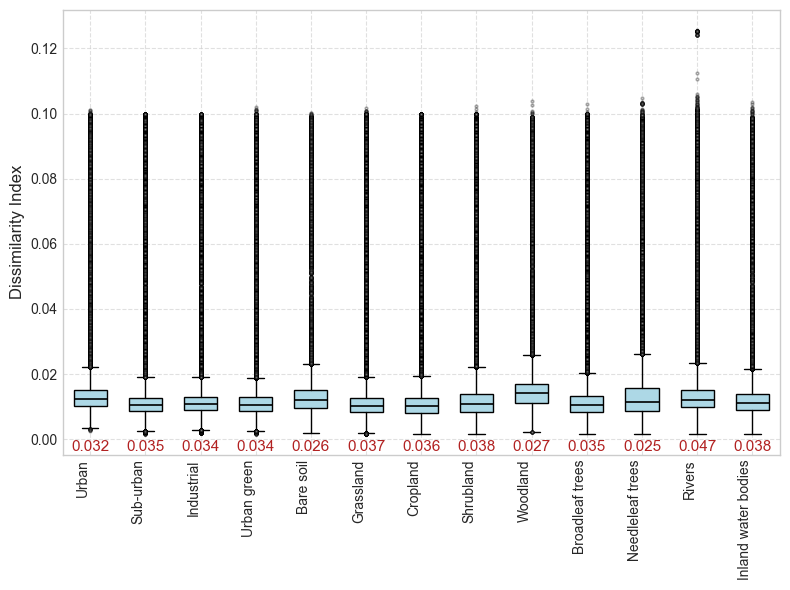

In [ ]:

# Configuration
dist_file = 'results/CLUSTER1_TRAIN_min_dist.csv'
train_file = 'data/CLUSTER1_TRAIN_cleaned_cities.csv'
batch_size = 1_000_000
scaling_factor =  0.7118433562961

# CORINE classes and labels
valid_classes = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
label_mapping = {
    1: "Urban", 2: "Sub-urban", 3: "Industrial", 4: "Urban green",
    6: "Bare soil", 7: "Grassland", 8: "Cropland", 9: "Shrubland",
    10: "Woodland", 11: "Broadleaf trees", 12: "Needleleaf trees",
    13: "Rivers", 14: "Inland water bodies", 15: "Sea"
}

# Initialize plot
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
x_positions = []
xtick_labels = []
upper_whisker_data = []

# Process each class independently
for idx, lc_class in enumerate(valid_classes):
    print(f"Processing LC_CORINE class {lc_class} - {label_mapping[lc_class]}")
    values = []

    dist_iter = pd.read_csv(dist_file, usecols=['dist'], chunksize=batch_size)
    train_iter = pd.read_csv(train_file, usecols=['LC_CORINE'], chunksize=batch_size)

    for dist_chunk, train_chunk in zip(dist_iter, train_iter):
        # Downcast to int and apply mask
        train_chunk['LC_CORINE'] = pd.to_numeric(train_chunk['LC_CORINE'], downcast='integer')
        mask = train_chunk['LC_CORINE'] == lc_class
        if not mask.any():
            continue

        # Extract, scale, and store values
        selected = dist_chunk.loc[mask, 'dist'] / scaling_factor
        values.extend(selected.values)

    if values:
        # Plot box for this class
        bp = ax.boxplot(
            values,
            positions=[idx],
            widths=0.6,
            patch_artist=True,
            boxprops=dict(facecolor="#add8e6", color="black", linewidth=1),
            whiskerprops=dict(color="black", linewidth=1),
            capprops=dict(color="black", linewidth=1),
            medianprops=dict(color="black", linewidth=1.2),
            flierprops=dict(marker="o", markersize=2, markerfacecolor="gray", alpha=0.3)
        )

        # Annotate outlier percentage
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        upper_whisker = q3 + 1.5 * iqr
        outlier_ratio = np.round(np.sum(np.array(values) > upper_whisker) / len(values), 3)
        ax.text(idx, -0.0045, f'{outlier_ratio}', ha='center', va='bottom', fontsize=11, color='firebrick')
        upper_whisker_data.append({'LC_CORINE': lc_class, 'Threshold': upper_whisker})

        x_positions.append(idx)
        xtick_labels.append(label_mapping[lc_class])

# Write thresholds to CSV
thresholds_df = pd.DataFrame(upper_whisker_data)
thresholds_df.to_csv('results/Thresholds_AOA_CL1.csv', index=False)

# Finalize plot
#ax.set_title('Dissimilarity Index by LC_CORINE Class', fontsize=14)
#ax.set_xlabel('LC_CORINE Class', fontsize=12)
ax.set_ylabel('Dissimilarity Index', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels(xtick_labels, rotation=90, ha='right')
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [2]:

# Columns to use
columns_order = [
    'IMPERV', 'HEIGHT', 'COAST', 'ELEV', 'POP',  
    'RH', 'SP', 'PRECIP', 'T_2M_COR', 'WS', 'TCC',  
    'CAPE', 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL'
]

# Load min-max scaling info and ensure correct matching
min_max_df = pd.read_csv("data/CLUSTER1_min_max.csv", sep=';')
min_max_df.set_index(min_max_df.columns[0], inplace=True)

# Ensure all required columns exist in the min-max file
missing_cols = [col for col in columns_order if col not in min_max_df.index]
if missing_cols:
    raise ValueError(f"The following required columns are missing in total_min_max.csv: {missing_cols}")

# Get min/max values in the same order as columns_order
min_vals = min_max_df.loc[columns_order, 'min'].astype(float).to_numpy()
max_vals = min_max_df.loc[columns_order, 'Max'].astype(float).to_numpy()

# Avoid division by zero
scale = max_vals - min_vals
scale[scale == 0] = 1.0

def min_max_scale(data, min_vals, scale):
    return (data - min_vals) / scale

In [3]:
# Load importances
importances_df = pd.read_csv('AOA_data/importances_CL1.csv')
importances_df.set_index('Feature', inplace=True)

# Map feature names to column names in test_scaled
importance_to_column_map = {
    'IMPERV': 'IMPERV',
    'HEIGHT': 'HEIGHT',
    'COAST': 'COAST',
    'ELEV': 'ELEV',
    'POP': 'POP',
    'RH': 'RH',
    'SP': 'SP',
    'PRECIP': 'PRECIP',
    'T_2M': 'T_2M_COR',  # Important mapping
    'wind_speed': 'WS',
    'TCC': 'TCC',
    'CAPE': 'CAPE',
    'BLH': 'BLH',
    'SSR': 'SSR',
    'SOLAR_ELEV': 'SOLAR_ELEV',
    'DECL': 'DECL'
}

# Build weights array in the same order as test_scaled columns
weights = np.array([
    importances_df.loc[feature, 'Importance'] 
    for feature in importance_to_column_map 
    if importance_to_column_map[feature] in columns_order
])


In [4]:
# Assume these are already defined
# from your_scaling_module import min_max_scale, min_vals, scale

columns_order = [
    'IMPERV', 'HEIGHT', 'COAST', 'ELEV', 'POP',  
    'RH', 'SP', 'PRECIP', 'T_2M_COR', 'WS', 'TCC',  
    'CAPE', 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL'
]
category_column = 'LC_CORINE'
for i in np.arange(1,16):
    print(f"working on category: {i}")
    target_category_value = i  # Change as needed

    csv_path = 'data/CLUSTER1_TRAIN_cleaned_cities.csv'
    chunksize = 1_000_000

    # Collect filtered data
    filtered_data = []
    chunk_idx = 0
    chunk_start_time = time.time()
    # Stream through the CSV
    for chunk in pd.read_csv(csv_path, usecols=columns_order + [category_column], chunksize=chunksize):
        chunk_idx += 1
        # Filter rows for the desired category
        matches = chunk[chunk[category_column] == target_category_value]
        
        if not matches.empty:
            scaled = min_max_scale(matches[columns_order].to_numpy(), min_vals, scale) * weights
            filtered_data.append(pd.DataFrame(scaled))

        duration = time.time() - chunk_start_time
        print(f"Chunk {chunk_idx} processed in {duration:.2f}s")
        chunk_start_time = time.time()

    # Combine all matching rows into one DataFrame
    if filtered_data:
        combined_df = pd.concat(filtered_data, ignore_index=True)
        tree = KDTree(combined_df, leaf_size=40)

        # Save KDTree to disk
        os.makedirs('trees', exist_ok=True)
        os.makedirs('trees/CL1', exist_ok=True)
        tree_path = f'trees/CL1/CLUSTER1_KDTREE_{target_category_value}.joblib'
        joblib.dump(tree, tree_path)

        print(f"KDTree saved to: {tree_path}")
    else:
        print(f"No data found for LC_CORINE == {target_category_value}")

working on category: 1
Chunk 1 processed in 3.20s
Chunk 2 processed in 3.18s
Chunk 3 processed in 3.04s
Chunk 4 processed in 3.21s
Chunk 5 processed in 3.27s
Chunk 6 processed in 4.05s
Chunk 7 processed in 3.67s
Chunk 8 processed in 3.72s
Chunk 9 processed in 5.35s
Chunk 10 processed in 3.84s
Chunk 11 processed in 3.07s
Chunk 12 processed in 3.05s
Chunk 13 processed in 3.06s
Chunk 14 processed in 3.09s
Chunk 15 processed in 2.99s
Chunk 16 processed in 3.08s
Chunk 17 processed in 3.02s
Chunk 18 processed in 3.12s
Chunk 19 processed in 3.06s
Chunk 20 processed in 3.00s
Chunk 21 processed in 3.10s
Chunk 22 processed in 3.06s
Chunk 23 processed in 3.02s
Chunk 24 processed in 3.08s
Chunk 25 processed in 3.02s
Chunk 26 processed in 3.03s
Chunk 27 processed in 3.07s
Chunk 28 processed in 3.13s
Chunk 29 processed in 3.13s
Chunk 30 processed in 3.07s
Chunk 31 processed in 3.09s
Chunk 32 processed in 3.04s
Chunk 33 processed in 3.02s
Chunk 34 processed in 3.00s
Chunk 35 processed in 2.99s
Chunk 